In [1]:
from torch.optim import Adam
from experiments.partial import build_partial, plot_partial

from lafomo.datasets import DrosophilaSpatialTranscriptomics, ToySpatialTranscriptomics
from lafomo.trainers import PartialPreEstimator
from lafomo.plot import plot_spatiotemporal_data
from lafomo.utilities.torch import spline_interpolate_gradient, softplus

from matplotlib import pyplot as plt
import torch
from lafomo.configuration import VariationalConfiguration

In [2]:
drosophila = True

if drosophila:
    data = 'dros-kr'
    dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../../data', scale=True)
    params = dict(lengthscale=10,
                  sensitivity=0.0970,
                  decay=0.0764,
                  diffusion=0.0015,
                  parameter_grad=False,
                  warm_epochs=-1,
                  natural=False,
                  clamp=True)
else:
    data = 'toy-spatial'
    dataset = ToySpatialTranscriptomics(data_dir='../../../data')
    params = dict(lengthscale=0.3,
                  sensitivity=1,
                  decay=0.1,
                  diffusion=0.01,
                  natural=False,
                  clamp=False)
lfm, trainer, plotter = build_partial(
    dataset,
    params)
    # reload=f'../../../experiments/{data}/partial/0savedmodel')


t_sorted, dp [53.925 60.175 66.425 72.675 78.925 85.175 91.425 97.675] 6.25
x dp is set to 1.0
t_sorted, dp [25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5
 39.5 40.5 41.5 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5
 53.5 54.5 55.5 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5
 67.5 68.5 69.5 70.5 71.5 72.5 73.5 74.5 75.5 76.5 77.5 78.5 79.5 80.5
 81.5 82.5 83.5 84.5 85.5 86.5 87.5 88.5] 1.0


8 64


/Users/jacob/Documents/proj/torchcubicspline/torchcubicspline/interpolate.py:277: UserWarning: input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible (Triggered internally at  ../aten/src/ATen/native/BucketizationUtils.h:25.)
  index = torch.bucketize(t.detach(), self._t) - 1


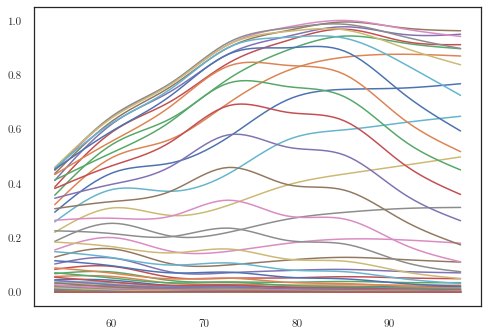

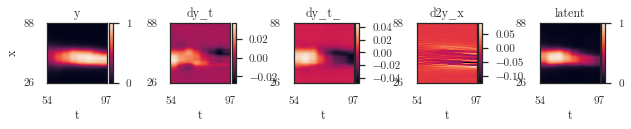

In [3]:
tx = trainer.tx
num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]
print(num_t, num_x)
y_target = trainer.y_target[0]
y_matrix = y_target.view(num_t, num_x)

dy_t = list()
for i in range(num_x):
    t = tx[0][::num_x]
    y = y_matrix[:, i].unsqueeze(-1)
    t_interpolate, y_interpolate, y_grad, _ = \
        spline_interpolate_gradient(t, y)
    plt.plot(t_interpolate, y_interpolate)
    dy_t.append(y_grad)
dy_t = torch.stack(dy_t)

d2y_x = list()
dy_x = list()
for i in range(num_t):
    t = tx[1][:num_x]
    y = y_matrix[i].unsqueeze(-1)
    t_interpolate, y_interpolate, y_grad, y_grad_2 = \
        spline_interpolate_gradient(t, y)
    d2y_x.append(y_grad_2)
    dy_x.append(y_grad)

d2y_x = torch.stack(d2y_x)
dy_x = torch.stack(dy_x)[..., ::10, 0].reshape(1, -1)
d2y_x = d2y_x[..., ::10, 0].reshape(1, -1)
dy_t = dy_t[..., ::10, 0].t().reshape(1, -1)

def pde_func(y, u, sensitivity, decay, diffusion):
    # y (1, 1681) u (25, 1, 41, 41) s (25, 1)
    dy_t = (sensitivity * u.view(u.shape[0], -1) -
            decay * y.view(1, -1) +
            diffusion * d2y_x)
    return dy_t

dy_t_ = pde_func(
    trainer.y_target,
    torch.tensor(dataset.orig_data[trainer.t_sorted, 2]).unsqueeze(0).repeat(25, 1),
    torch.tensor(params['sensitivity']).unsqueeze(0).repeat(25, 1),
    torch.tensor(params['decay']).unsqueeze(0).repeat(25, 1),
    torch.tensor(params['diffusion']).unsqueeze(0).repeat(25, 1))[0]

ts = tx[0, :].unique().numpy()
xs = tx[1, :].unique().numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]
axes = plot_spatiotemporal_data(
    [
        trainer.y_target.view(num_t, num_x).t(),
        dy_t.reshape(num_t, num_x).t(),
        dy_t_.view(num_t, num_x).t(),
        d2y_x.view(num_t, num_x).t(),
        torch.tensor(dataset.orig_data[trainer.t_sorted, 2]).view(num_t, num_x).t(),
    ],
    extent, titles=['y', 'dy_t', 'dy_t_', 'd2y_x', 'latent']
)

In [4]:
optimizers = [Adam(lfm.parameters(), lr=0.05)]

pre_estimator = PartialPreEstimator(
    lfm, optimizers, dataset, pde_func,
    input_pair=(trainer.tx, trainer.y_target), target=dy_t.t()
)

In [5]:
lfm.pretrain(True)
pre_estimator.train(100, report_interval=10)

Epoch 001/100 - Loss: 1.09 (1.09 0.00) kernel: [[[10.04973925 10.04841686]]]
Epoch 011/100 - Loss: 1.02 (0.90 0.12) kernel: [[[10.31341888 10.08204615]]]
Epoch 021/100 - Loss: 0.73 (0.69 0.04) kernel: [[[10.6660345  10.25134681]]]
Epoch 031/100 - Loss: 0.47 (0.46 0.01) kernel: [[[11.02130188 10.53568503]]]
Epoch 041/100 - Loss: 0.23 (0.23 0.01) kernel: [[[11.48972825 11.01789187]]]
Epoch 051/100 - Loss: -0.02 (-0.03 0.01) kernel: [[[12.12258906 11.65820965]]]
Epoch 061/100 - Loss: -0.26 (-0.28 0.02) kernel: [[[12.88003279 12.41197732]]]
Epoch 071/100 - Loss: -0.50 (-0.53 0.03) kernel: [[[13.71106693 13.22545929]]]
Epoch 081/100 - Loss: -0.74 (-0.78 0.04) kernel: [[[14.59975688 14.06282427]]]
Epoch 091/100 - Loss: -0.98 (-1.03 0.05) kernel: [[[15.52005909 14.94932434]]]


In [6]:
# xy = lfm.gp_model.variational_strategy.base_variational_strategy.inducing_points.squeeze()
# # c = lfm.gp_model.variational_strategy.base_variational_strategy._variational_distribution.natural_vec
# c = lfm.gp_model.variational_strategy.base_variational_strategy._variational_distribution.variational_mean
# plt.scatter(xy[:, 0], xy[:, 1], c=c.detach())
# plt.colorbar()

Mean output variance: 0.008781046920945992
Test loss: -0.15148573589272815
Q2: 0.905
Epoch 021/030 - Loss: 0.06 (-0.19 0.25) kernel: [[[17.16883705 16.29765992]]] s: 0.0970000239062052 dec: 0.07639997519055218 diff: 0.0014999576719171928
Epoch 022/030 - Loss: 0.06 (-0.19 0.25) kernel: [[[17.19422006 16.30041701]]] s: 0.0970000239062052 dec: 0.07639997519055218 diff: 0.0014999576719171928
Epoch 023/030 - Loss: 0.06 (-0.19 0.24) kernel: [[[17.21930209 16.30258662]]] s: 0.0970000239062052 dec: 0.07639997519055218 diff: 0.0014999576719171928
Epoch 024/030 - Loss: 0.05 (-0.17 0.23) kernel: [[[17.2438882  16.30619597]]] s: 0.0970000239062052 dec: 0.07639997519055218 diff: 0.0014999576719171928
Epoch 025/030 - Loss: 0.02 (-0.19 0.21) kernel: [[[17.26757173 16.30903585]]] s: 0.0970000239062052 dec: 0.07639997519055218 diff: 0.0014999576719171928
Epoch 026/030 - Loss: 0.02 (-0.18 0.20) kernel: [[[17.28926156 16.31154966]]] s: 0.0970000239062052 dec: 0.07639997519055218 diff: 0.00149995767191719

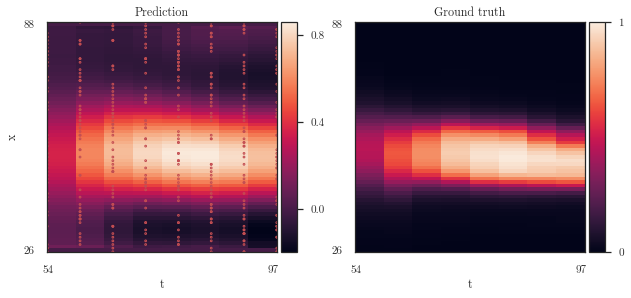

In [12]:
trainer.plot_outputs = True
lfm.pretrain(False)
trainer.train(10, report_interval=1)

In [8]:
a = dict(lfm.named_parameters())
for key in a:
    print(key, a[key].shape)

print(hi)

fenics0 torch.Size([1, 1])
fenics1 torch.Size([1, 1])
fenics2 torch.Size([1, 1])
gp_model.variational_strategy.base_variational_strategy._variational_distribution.variational_mean torch.Size([1, 426])
gp_model.variational_strategy.base_variational_strategy._variational_distribution.chol_variational_covar torch.Size([1, 426, 426])
gp_model.mean_module.constant torch.Size([1, 1])
gp_model.covar_module.raw_lengthscale torch.Size([1, 1, 2])
likelihood.raw_task_noises torch.Size([1])
likelihood.raw_noise torch.Size([1])


NameError: name 'hi' is not defined

In [21]:
[softplus(param) for param in lfm.fenics_parameters]

[tensor([[0.0970]], dtype=torch.float64),
 tensor([[0.0764]], dtype=torch.float64),
 tensor([[0.0015]], dtype=torch.float64)]

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


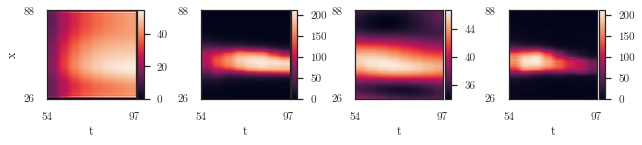

In [9]:
from pathlib import Path
plot_partial(dataset, lfm, trainer, plotter, Path('./'), params)

torch.Size([512, 1])


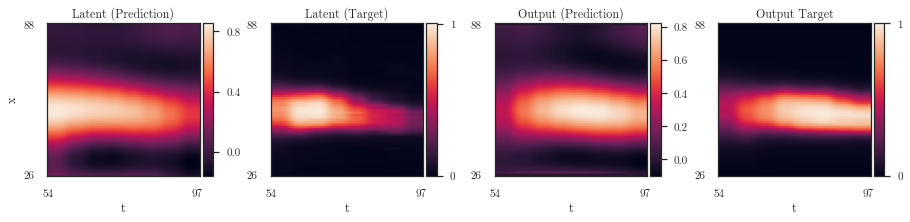

In [11]:
from lafomo.plot import plot_spatiotemporal_data
lfm.eval()
f = lfm(tx)
f_mean = f.mean.detach()
f_var = f.variance.detach()
y_target = trainer.y_target[0]
ts = tx[0, :].unique().sort()[0].numpy()
xs = tx[1, :].unique().sort()[0].numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]

# print(dataset.orig_data[:, 2])
l_target = torch.tensor(dataset.orig_data[:, 2])
l = lfm.gp_model(tx.t())
l_mean = l.mean.detach()
# plt.imshow(l_mean.view(num_t, num_x).transpose(0, 1))
print(l_mean.shape)
plot_spatiotemporal_data(
    [
        l_mean.view(num_t, num_x).t(),
        l_target.view(num_t, num_x).t(),
        f_mean.view(num_t, num_x).t(),
        y_target.view(num_t, num_x).detach().t(),
    ],
    extent,
    titles=['Latent (Prediction)', 'Latent (Target)', 'Output (Prediction)', 'Output Target'],
    cticks=None#[0, 100, 200]
)
plt.gca().get_figure().set_size_inches(15, 7)

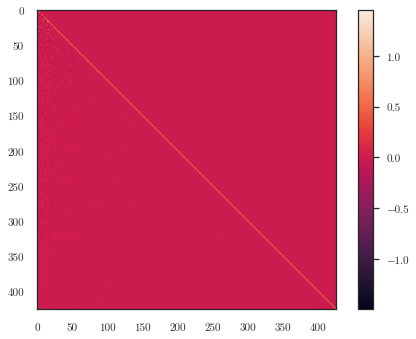

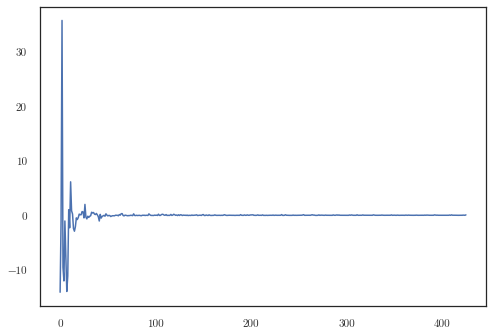

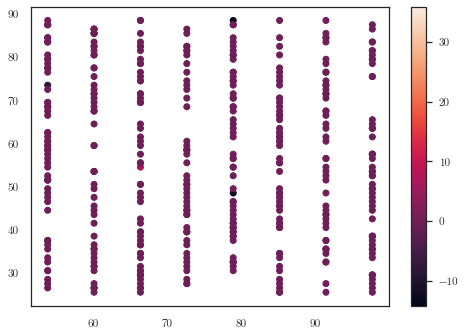

In [10]:
xy = lfm.gp_model.variational_strategy.base_variational_strategy.inducing_points.squeeze()
# # c = lfm.gp_model.variational_strategy.base_variational_strategy._variational_distribution.natural_vec
# c = lfm.gp_model.variational_strategy.base_variational_strategy._variational_distribution.variational_mean
a = dict(lfm.named_parameters())
k = a['gp_model.variational_strategy.base_variational_strategy._variational_distribution.chol_variational_covar'].squeeze()
k = torch.matmul(k, k)
plt.imshow(k.detach())
plt.colorbar()
plt.figure()
mean = a['gp_model.variational_strategy.base_variational_strategy._variational_distribution.variational_mean'].squeeze().detach()
plt.plot(mean)
plt.figure()
plt.scatter(xy[:, 0], xy[:, 1], c=mean)
plt.colorbar()

In [ ]:
import torch
fig, ax = plt.subplots()
ax.imshow(torch.randn(10, 10))
ax.grid()
print(ax)

In [6]:
print(lfm.gp_model.mean_module.constant)



Parameter containing:
tensor([[38.8738]], dtype=torch.float64, requires_grad=True)
